In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import numpy as np
from typing import List, Tuple
import pickle
import time
from torch.utils.data import ConcatDataset, Dataset, Subset
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [2]:
train_dataset = MNIST('D:/downloads/btp/outputforpaper/FashionMnist', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('D:/downloads/btp/outputforpaper/FashionMnist', train=False, download=True, transform=transforms.ToTensor())

In [3]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
classes = 10
input_dim = 784
num_clients = 25
rounds = 50
batch_size = 32
in_group_rounds=5
epochs_per_client =5
learning_rate = 2e-2
num_malicious_clients=5

In [4]:
total_train_size, total_test_size

(60000, 10000)

In [5]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()


def average_models(new_model, next, scale):
    if new_model == None:
        new_model = next
        for key in new_model:
            new_model[key] = new_model[key] * scale
    else:
        for key in new_model:
            new_model[key] = new_model[key] + (next[key] * scale)
    return new_model

In [6]:
class FederatedNet(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
    
    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history
    
    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [7]:
def partition_data_label_quantity(
    num_clients, labels_per_client, train_dataset,total_train_size,seed=42):
    trainset=train_dataset
    prng = np.random.default_rng(seed)

    targets = trainset.targets
    if isinstance(targets, list):
        targets = np.array(targets)
    if isinstance(targets, torch.Tensor):
        targets = targets.numpy()
    num_classes = len(set(targets))
    times = [0 for _ in range(num_classes)]
    contains = []

    for i in range(num_clients):
        current = [i % num_classes]
        times[i % num_classes] += 1
        j = 1
        while j < labels_per_client:
            index = prng.choice(num_classes, 1)[0]
            if index not in current:
                current.append(index)
                times[index] += 1
                j += 1
        contains.append(current)
    idx_clients: List[List] = [[] for _ in range(num_clients)]
    for i in range(num_classes):
        idx_k = np.where(targets == i)[0]
        prng.shuffle(idx_k)
        idx_k_split = np.array_split(idx_k, times[i])
        ids = 0
        for j in range(num_clients):
            if i in contains[j]:
                idx_clients[j] += idx_k_split[ids].tolist()
                ids += 1
    trainsets_per_client = [Subset(trainset, idxs) for idxs in idx_clients]
    return trainsets_per_client

In [8]:
client_datasets = partition_data_label_quantity(num_clients,2,train_dataset,len(train_dataset))

FL

In [9]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.load_state_dict(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        return net.state_dict()

In [10]:
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [11]:
fl_start_time = time.time()

global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
history_fl = []
traffic=[]
weights=[]
load_model=None
total_length_dataset=len(train_dataset)
for i in range(rounds):
    new_model=None
    curr_parameters = global_net.state_dict()
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size()/total_length_dataset
        new_model=average_models(new_model,client_parameters,fraction)
    load_model=new_model.copy()
    params = list(load_model)
    total_norm = 0.0
    for key, value in load_model.items():
        total_norm += torch.norm(value.view(-1)).item()
    weights.append(total_norm)
    global_net.load_state_dict(new_model)
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    traffic.append(2*num_clients)
    history_fl.append((train_acc, dev_acc,i))

fl_end_time = time.time()
fl_time = fl_end_time - fl_start_time

After round 1, train_loss = 1.8374, dev_loss = 1.827, dev_acc = 0.4066

After round 2, train_loss = 1.2498, dev_loss = 1.2302, dev_acc = 0.7324

After round 3, train_loss = 0.8997, dev_loss = 0.8772, dev_acc = 0.7778

After round 4, train_loss = 0.6766, dev_loss = 0.6536, dev_acc = 0.8203

After round 5, train_loss = 0.5234, dev_loss = 0.5007, dev_acc = 0.8651

After round 6, train_loss = 0.4282, dev_loss = 0.4073, dev_acc = 0.8879

After round 7, train_loss = 0.3717, dev_loss = 0.352, dev_acc = 0.9011

After round 8, train_loss = 0.3332, dev_loss = 0.3144, dev_acc = 0.909

After round 9, train_loss = 0.3004, dev_loss = 0.2815, dev_acc = 0.9188

After round 10, train_loss = 0.2716, dev_loss = 0.2552, dev_acc = 0.9262

After round 11, train_loss = 0.254, dev_loss = 0.2381, dev_acc = 0.9311

After round 12, train_loss = 0.2393, dev_loss = 0.2237, dev_acc = 0.9357

After round 13, train_loss = 0.2263, dev_loss = 0.2105, dev_acc = 0.938

After round 14, train_loss = 0.2162, dev_loss = 0.20

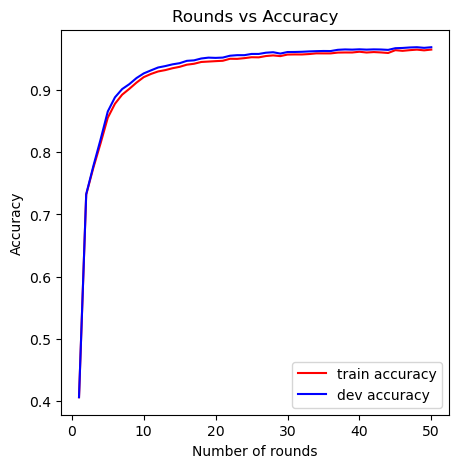

In [12]:
plt.plot([i + 1 for i in range(len(history_fl))], [history_fl[i][0] for i in range(len(history_fl))], color='r', label='train accuracy')
plt.plot([i + 1 for i in range(len(history_fl))], [history_fl[i][1] for i in range(len(history_fl))], color='b', label='dev accuracy')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

In [13]:
print(max(history_fl))
print(traffic[0])

(0.9644799828529358, 0.9682555198669434, 49)
50


DFL

In [14]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
        self.client_data=[]
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.load_state_dict(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        return net.state_dict()
    
    def recieve_parameters(self,client_id,client_parameter,fraction):
        client_object={"client_id":client_id,"client_parameter":client_parameter,"fraction":fraction}
        self.client_data.append(client_object)

    def aggregated_parameters(self):
            local_aggregated_model=None
            for i in range(0,len(self.client_data)):
                 local_aggregated_model=average_models(local_aggregated_model,self.client_data[i]["client_parameter"],self.client_data[i]["fraction"])
            self.client_data.clear()
            return local_aggregated_model

In [15]:
clients = [Client(i, client_datasets[i]) for i in range(num_clients)]

In [16]:
dfl_start_time = time.time()

global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
history_dfl = []
weights=[]
traffic=[]
load_model=None
total_data_size=len(train_dataset)
for i in range(rounds):
    new_model=None
    for client in clients:
        fraction = client.get_dataset_size()/total_data_size
        if i == 0:
            client_parameters=client.train(curr_parameters)
        else:
            client_parameters = client.train(client.aggregated_parameters())
        for clt in clients:
                clt.recieve_parameters(client.get_client_id(),client_parameters,fraction)
        new_model=average_models(new_model,client_parameters,fraction)
    


    load_model=new_model.copy()
    params = list(load_model)
    total_norm = 0.0
    for key, value in load_model.items():
            total_norm += torch.norm(value.view(-1)).item()
    weights.append(total_norm)
    global_net.load_state_dict(new_model)
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    traffic.append((num_clients)*(num_clients-1))
    history_dfl.append((train_acc, dev_acc,i))

dfl_end_time = time.time()
dfl_time  =dfl_end_time - dfl_start_time

After round 1, train_loss = 1.8647, dev_loss = 1.8552, dev_acc = 0.4096

After round 2, train_loss = 0.9589, dev_loss = 0.9404, dev_acc = 0.8177

After round 3, train_loss = 0.4847, dev_loss = 0.473, dev_acc = 0.8677

After round 4, train_loss = 0.3562, dev_loss = 0.345, dev_acc = 0.9056

After round 5, train_loss = 0.2977, dev_loss = 0.2871, dev_acc = 0.9203

After round 6, train_loss = 0.2548, dev_loss = 0.2449, dev_acc = 0.9338

After round 7, train_loss = 0.2313, dev_loss = 0.2209, dev_acc = 0.9403

After round 8, train_loss = 0.2111, dev_loss = 0.2005, dev_acc = 0.947

After round 9, train_loss = 0.1995, dev_loss = 0.1899, dev_acc = 0.9489

After round 10, train_loss = 0.1876, dev_loss = 0.1789, dev_acc = 0.9519

After round 11, train_loss = 0.1723, dev_loss = 0.1631, dev_acc = 0.9584

After round 12, train_loss = 0.17, dev_loss = 0.1611, dev_acc = 0.9571

After round 13, train_loss = 0.1671, dev_loss = 0.1582, dev_acc = 0.9567

After round 14, train_loss = 0.1617, dev_loss = 0.15

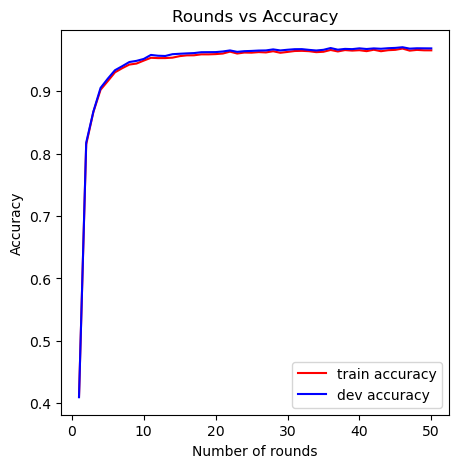

In [17]:
plt.plot([i + 1 for i in range(len(history_dfl))], [history_dfl[i][0] for i in range(len(history_dfl))], color='r', label='train accuracy')
plt.plot([i + 1 for i in range(len(history_dfl))], [history_dfl[i][1] for i in range(len(history_dfl))], color='b', label='dev accuracy')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

In [18]:
print(max(history_dfl))
print(traffic[0])

(0.968594491481781, 0.9707278609275818, 45)
600


HDFL

In [19]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
classes = 10
input_dim = 784
num_clients = 25
rounds = 45
batch_size = 64
in_group_rounds=5
epochs_per_client =5
learning_rate = 2e-2
num_malicious_clients=5

In [20]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
        self.client_data=[]
        self.server_id=-1
        self.distance=random.randint(1,100)
        self.client_data_server=[]
    
    def set_server_id(self,client_id):
        self.client_data_server=[]
        self.server_id=client_id
    
    def get_server_id(self):
        return self.server_id
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.load_state_dict(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        return net.state_dict()
    
    def recieve_parameters(self,client_id,client_parameter,fraction):
        client_object={"client_id":client_id,"client_parameter":client_parameter,"fraction":fraction}
        self.client_data.append(client_object)

    def aggregated_parameters(self):
            local_aggregated_model=None
            for i in range(0,len(self.client_data)):
                 local_aggregated_model=average_models(local_aggregated_model,self.client_data[i]["client_parameter"],self.client_data[i]["fraction"])
            self.client_data.clear()
            return local_aggregated_model
    
    def recieve_data_as_server(self,client_parameter,fraction):
        client_object={"client_parameter":client_parameter,"fraction":fraction}
        self.client_data_server.append(client_object)
    

    def aggregate_parameter_as_server(self):
         local_aggregated_model_as_server=None
         for data in self.client_data_server:
              local_aggregated_model_as_server=average_models(local_aggregated_model_as_server,data["client_parameter"],data["fraction"])
         self.client_data_server.clear()
         return local_aggregated_model_as_server   

In [51]:
def dissimilarity_utility_function(client_set_1, client_set_2, data):
    client_set_1_average = {}
    client_set_2_average = {}
    for i in client_set_1:
        client_set_1_average = average_models(client_set_1_average, data[i], 1)
    for i in client_set_2:
        client_set_2_average = average_models(client_set_2_average, data[i], 1)

    # Ensure client_set_1_average and client_set_2_average are not empty before proceeding
    if not client_set_1_average or not client_set_2_average:
        return float('inf')  # Return a high dissimilarity if averages are not computed
    
    model1_weights = []
    model2_weights = []
    for key, value in client_set_1_average.items():
        model1_weights.append(value.detach().cpu())
    for key, value in client_set_2_average.items():
        model2_weights.append(value.detach().cpu())
    
    weight1_flat = torch.cat([param.view(-1) for param in model1_weights])
    weight2_flat = torch.cat([param.view(-1) for param in model2_weights])
    
    # Using cosine similarity to compute similarity and then flipping it to reflect dissimilarity
    cosine_sim = torch.nn.functional.cosine_similarity(weight1_flat, weight2_flat, dim=0)
    dissimilarity_score = 1 - cosine_sim.item()  # Higher values indicate more dissimilarity
    
    return dissimilarity_score

In [58]:
def utility_function(client_set_1,client_set_2,data):
  client_set_1_average=None
  client_set_2_average=None
  for i in client_set_1:
    client_set_1_average=average_models(client_set_1_average,data[i],1)
  for i in client_set_2:
    client_set_2_average=average_models(client_set_2_average,data[i],1)
  model1_weights = []
  model2_weights = []
  for key, value in client_set_1_average.items():
      model1_weights.append(value.detach().cpu())

  for key, value in client_set_2_average.items():
      model2_weights.append(value.detach().cpu())
  weight1_flat = torch.cat([param.view(-1) for param in model1_weights])
  weight2_flat = torch.cat([param.view(-1) for param in model2_weights])
  cosine_sim = torch.nn.functional.cosine_similarity(weight1_flat, weight2_flat, dim=0)
  dissimilarity_score = 1 - cosine_sim.item()
  return dissimilarity_score

In [65]:
def generateGroupsGame(data,num_clients):
    groups=[]
    for i in range(0,num_clients):
        groups.append([i])
    while True:
        for group in groups:
            for x in group:
                no_change_flag=0
                max_group=None
                max_utility=0
                for g in groups:
                    if g!=group:
                        if len(g) >= 1 and len(group) > 1:
                            tempset_1=g.copy()
                            tempset_1.append(x)
                            tempset_2=group.copy()
                            tempset_2.remove(x)
                            if utility_function(tempset_1,tempset_2,data) > utility_function(g,group,data): 
                                if max_utility < utility_function(tempset_1,tempset_2,data):
                                    max_group=g
                                    max_utility=utility_function(tempset_1,tempset_2,data)        
                        elif len(group)<=1:
                            if utility_function(g,group,data) > max_utility:
                                max_group=g
                                max_utility=utility_function(g,group,data)
                if max_group is not None:  
                    group.remove(x)
                    max_group.append(x)
                    no_change_flag=1
                    if len(group) <=0 :
                        groups.remove(group)
        if no_change_flag == 0:
            break
    print("end")
    return groups

In [52]:
def generate_dissimilar_groups(data, num_clients):
    groups = [[i] for i in range(num_clients)]
    
    while True:
        no_change_flag = False  # Flag to detect if no changes occur in an iteration
        
        for group in groups:
            for x in group:
                best_group = None
                best_utility = -float('inf')
                
                for other_group in groups:
                    if other_group != group:
                        # Evaluate the impact of moving x from `group` to `other_group`
                        temp_set_1 = other_group.copy()
                        temp_set_1.append(x)
                        
                        temp_set_2 = group.copy()
                        temp_set_2.remove(x)
                        
                        current_utility = dissimilarity_utility_function(temp_set_1, temp_set_2, data)
                        
                        if current_utility > best_utility:
                            best_group = other_group
                            best_utility = current_utility
                
                # If a better group is found for x, move it
                if best_group:
                    group.remove(x)
                    best_group.append(x)
                    no_change_flag = True
                    
                    # Remove the group if it's empty after moving x
                    if len(group) == 0:
                        groups.remove(group)
        print(group
        if not no_change_flag:
            break  # Exit loop if no changes occurred in this iteration
    
    print("Clustering complete")
    return groups

In [61]:
def groupDataLength(groups,clients):
    group_dataset_length=[]
    for grp in groups:
        totalcount=0
        for clt in grp:
            totalcount+=clients[clt].get_dataset_size()
        group_dataset_length.append(totalcount)
    return group_dataset_length

In [62]:
clients = [Client(i, client_datasets[i]) for i in range(num_clients)]

In [63]:
global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
data = []
for client in clients:
    paramerter=client.train(curr_parameters)
    data.append(paramerter)

In [66]:
groups=generateGroupsGame(data,num_clients)
print(groups)
group_dataset_length=groupDataLength(groups,clients)

end
[[4], [6, 20, 11], [18, 24, 14, 19, 10, 21], [15], [0, 8], [23, 7, 13, 9, 1, 2, 12], [5, 22, 16], [3, 17]]


In [ ]:
hdfl_start_time = time.time()

global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
history_hdfl = []
weights=[]
traffic=[]
load_model=None
total_dataset_length=len(train_dataset)
flag=True
for i in range(rounds):
    traffic_single_sum=0
    #chosing the server client with a uniform probability
    server=[]
    for grp in groups:
        traffic_single_sum=traffic_single_sum+len(grp)-1
        server_id=np.random.choice(grp,p=np.ones(len(grp))/len(grp))
        server.append(server_id)
        clients[server_id].set_server_id(server_id)
    #in group mesh decentralized learning
    k=0
    for grp in groups:
        flag=True
        for j in range(in_group_rounds):
            traffic_single_sum=traffic_single_sum+((len(grp)-1)*len(grp))
            for clt in grp:
                fraction = clients[clt].get_dataset_size()/group_dataset_length[k]
                if i == 0 and flag :
                    client_parameters=clients[clt].train(curr_parameters)
                elif j == 0:
                    client_parameters=clients[clt].train(load_model)
                else:
                    client_parameters = clients[clt].train(clients[clt].aggregated_parameters())
                for clt_1 in grp:
                        clients[clt_1].recieve_parameters(clt_1,client_parameters,fraction)
            flag=False
        #aggregating on the random choosn server
        for clt in grp:
                fraction = clients[clt].get_dataset_size()/group_dataset_length[k]
                t=clients[clt].aggregated_parameters()
                clients[server[k]].recieve_data_as_server(t,fraction)
        k+=1
    #aggregating the parameters
    aggregateds=[]
    for clt in server:
            t=clients[clt].aggregate_parameter_as_server()
            aggregateds.append(t)
    #choosing the server from the amongst server at unifrom probability
    server_id=np.random.choice(server,p=np.ones(len(server))/len(server))
    clients[server_id].set_server_id(server_id)
    traffic_single_sum=traffic_single_sum+len(server)
    #sending the data to the chosen from all the group server
    group_number=0
    for clt in aggregateds:
            fraction=group_dataset_length[group_number]/total_dataset_length
            group_number+=1
            clients[server_id].recieve_data_as_server(clt,fraction)
    #aggregating at the top level server
    traffic_single_sum=traffic_single_sum+num_clients        
    aggregated_parameters_top=clients[server_id].aggregate_parameter_as_server()
    load_model=aggregated_parameters_top.copy()
    total_norm = 0.0
    for key, value in load_model.items():
            total_norm += torch.norm(value.view(-1)).item()
    weights.append(total_norm)
    global_net.load_state_dict(load_model)
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    traffic.append(traffic_single_sum)
    history_hdfl.append((train_acc, dev_acc,i))

hdfl_end_time = time.time()
hdfl_time = hdfl_end_time - hdfl_start_time

After round 1, train_loss = 1.6506, dev_loss = 1.6388, dev_acc = 0.637

After round 2, train_loss = 1.0592, dev_loss = 1.0388, dev_acc = 0.8398

After round 3, train_loss = 0.7191, dev_loss = 0.6995, dev_acc = 0.8985

After round 4, train_loss = 0.6365, dev_loss = 0.6168, dev_acc = 0.9278

After round 5, train_loss = 0.4536, dev_loss = 0.436, dev_acc = 0.9423

After round 6, train_loss = 0.3405, dev_loss = 0.3265, dev_acc = 0.9443

After round 7, train_loss = 0.2943, dev_loss = 0.2808, dev_acc = 0.9541

After round 8, train_loss = 0.2361, dev_loss = 0.225, dev_acc = 0.9568

After round 9, train_loss = 0.2673, dev_loss = 0.2534, dev_acc = 0.9584

After round 10, train_loss = 0.1782, dev_loss = 0.168, dev_acc = 0.9606

After round 11, train_loss = 0.1537, dev_loss = 0.1448, dev_acc = 0.9644

After round 12, train_loss = 0.1473, dev_loss = 0.1391, dev_acc = 0.9669

After round 13, train_loss = 0.128, dev_loss = 0.1217, dev_acc = 0.9702

After round 14, train_loss = 0.1151, dev_loss = 0.10

In [ ]:
plt.plot([i + 1 for i in range(len(history_hdfl))], [history_hdfl[i][0] for i in range(len(history_hdfl))], color='r', label='train accuracy')
plt.plot([i + 1 for i in range(len(history_hdfl))], [history_hdfl[i][1] for i in range(len(history_hdfl))], color='b', label='dev accuracy')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
print(max(history_hdfl))
print(traffic[0])

In [ ]:
plt.plot([i + 1 for i in range(len(history_fl))], [history_fl[i][1] for i in range(len(history_fl))], color='b', label='FL dev accuracy')
plt.plot([i + 1 for i in range(len(history_dfl))], [history_dfl[i][1] for i in range(len(history_dfl))], color='r', label='DFL dev accuracy')
plt.plot([i + 1 for i in range(len(history_hdfl))], [history_hdfl[i][1] for i in range(len(history_hdfl))], color='g', label='HDFL dev accuracy')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
labels = ['FL', 'DFL', 'HDFL']
values = [fl_time, dfl_time, hdfl_time]

# Plot the bar graph
plt.bar(labels, values, color=['blue', 'green', 'red'])

# Add labels and title
plt.xlabel('')
plt.ylabel('RUN TIME')
plt.title('Run Time for FL, DFL & HDFL')

# Show the plot
plt.show()